# KNN for Dataset Adult

PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

Testando kNN com a base adult obtida no UCI repository. Iniciando com carregamento da base e com análise básica da base e dos atributos.

Tarefa: construir classificador para a variável "Target (<=50K or >50K) com KNN

Autor: Eduardo AV Salis


## 1. Bibliotecas Básicas

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier



----

## 2. Dataset

In [34]:
original_df = pd.read_csv("train_data.csv", na_values='?')
df_train = original_df.copy()

In [35]:
df_train.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [36]:
#df_train.drop("Id",axis=1,inplace=True)

In [37]:
to_be_renamed = {"education.num":"education_num","marital.status": "marital_status",'hours.per.week':"hours_per_week", "native.country" : 'native_country',"capital.gain" : "capital_gain", "capital.loss":"capital_loss"}
df_train.rename(columns=to_be_renamed,inplace=True)

In [38]:
df_train.describe()

,Id,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32560.000000,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,32559.500000,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,9399.406719,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,16280.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,24419.750000,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,32559.500000,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,40699.250000,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,48839.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              32560 non-null  int64 
 1   age             32560 non-null  int64 
 2   workclass       30724 non-null  object
 3   fnlwgt          32560 non-null  int64 
 4   education       32560 non-null  object
 5   education_num   32560 non-null  int64 
 6   marital_status  32560 non-null  object
 7   occupation      30717 non-null  object
 8   relationship    32560 non-null  object
 9   race            32560 non-null  object
 10  sex             32560 non-null  object
 11  capital_gain    32560 non-null  int64 
 12  capital_loss    32560 non-null  int64 
 13  hours_per_week  32560 non-null  int64 
 14  native_country  31977 non-null  object
 15  income          32560 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


In [40]:
df_train.head()

,Id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [41]:
df_train.shape

(32560, 16)

----

## 3. EDA

### 3.1 Categóricas

In [42]:
categ = ['workclass','education',"marital_status","occupation","relationship","race","sex","native_country"]

""" 
for feature in categ:
    plt.figure(figsize=(10,5))
    plt.title(f'Countplot de {feature}')
    ax = sns.countplot(x=feature ,data = df_train)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.show()
"""

" \nfor feature in categ:\n    plt.figure(figsize=(10,5))\n    plt.title(f'Countplot de {feature}')\n    ax = sns.countplot(x=feature ,data = df_train)\n    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)\n    plt.show()\n"

In [43]:
""" 
for feature in categ:
    df_train.groupby(['income', feature]).size().reset_index().pivot(columns='income', index=feature, values=0).plot(
        kind='bar', stacked=True, title=f"Distribuição da variável alvo em {feature}")
    #plt.show()
"""

' \nfor feature in categ:\n    df_train.groupby([\'income\', feature]).size().reset_index().pivot(columns=\'income\', index=feature, values=0).plot(\n        kind=\'bar\', stacked=True, title=f"Distribuição da variável alvo em {feature}")\n    #plt.show()\n'

### 3.2 Variáveis numéricas

In [44]:
""" 
plt.figure(figsize=(10,5))
ax = sns.displot(df_train.age, kde=False, color='blue')
"""

" \nplt.figure(figsize=(10,5))\nax = sns.displot(df_train.age, kde=False, color='blue')\n"

In [45]:
"""
plt.figure(figsize=(10,5))
ax = sns.displot(df_train[df_train['income'] =="<=50K"].age, kde=False, color='y')
"""

'\nplt.figure(figsize=(10,5))\nax = sns.displot(df_train[df_train[\'income\'] =="<=50K"].age, kde=False, color=\'y\')\n'

In [46]:
"""
plt.figure(figsize=(10,5))
ax = sns.displot(df_train[df_train['income'] ==">50K"].age, kde=False, color='green')
"""

'\nplt.figure(figsize=(10,5))\nax = sns.displot(df_train[df_train[\'income\'] ==">50K"].age, kde=False, color=\'green\')\n'

In [47]:
numeric = ['fnlwgt','education_num',"capital_gain","capital_loss","hours_per_week"]
"""
for feature in numeric:
    plt.figure(figsize=(10,5))
    plt.title(f'Violinplot de {feature}')
    ax = sns.violinplot(x="income", y=feature ,data = df_train)
    plt.show()
"""


'\nfor feature in numeric:\n    plt.figure(figsize=(10,5))\n    plt.title(f\'Violinplot de {feature}\')\n    ax = sns.violinplot(x="income", y=feature ,data = df_train)\n    plt.show()\n'

### 3.3 Dados do alvo desbalanceados

In [48]:
""" 
plt.figure(figsize=(10,5))
ax = sns.countplot(x='income' ,data = df_train)
"""

" \nplt.figure(figsize=(10,5))\nax = sns.countplot(x='income' ,data = df_train)\n"

----

## 4 Pre - processamento

In [49]:

df_train['income'] = df_train['income'].replace({
    "<=50K": 0, 
    ">50K":1 
}) 


### 4.1 Lidando com dados nulos

In [50]:
#Caso retira-se todos os nulos perderia 13% das observações
print(df_train.isna().sum().sum()/df_train.shape[0])

0.13089680589680588


In [51]:
#verificando a proporção entre as colunas
print(round(df_train.isna().sum()/df_train.shape[0],2))

Id                0.00
age               0.00
workclass         0.06
fnlwgt            0.00
education         0.00
education_num     0.00
marital_status    0.00
occupation        0.06
relationship      0.00
race              0.00
sex               0.00
capital_gain      0.00
capital_loss      0.00
hours_per_week    0.00
native_country    0.02
income            0.00
dtype: float64


### Substituindo os valores nulos pelos mais frequentes

In [52]:
imp = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
df_train['workclass'] = imp.fit_transform(df_train['workclass'].values.reshape(-1,1))[:,0]
df_train['occupation'] = imp.fit_transform(df_train['occupation'].values.reshape(-1,1))[:,0]
df_train['native_country'] = imp.fit_transform(df_train['native_country'].values.reshape(-1,1))[:,0]

### 4.2 Seleção e "engenharia" de atributos

In [53]:
#penso que as variáveis education e education.num são redundantes
df_train.drop("education",axis=1, inplace=True)
df_train['capital_diff'] = df_train['capital_gain'].sub(df_train['capital_loss'])
df_train.drop(["capital_gain","capital_loss"],axis=1, inplace=True)

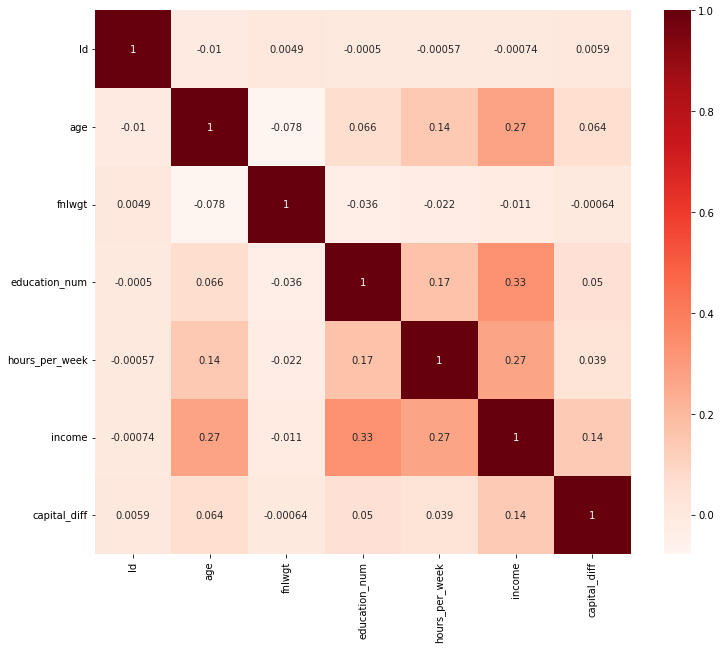

In [54]:
plt.figure(figsize=(12,10))
cor = df_train.corr(method="spearman")
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### 4.3 Tratando variáveis categóricas

In [55]:
#label encoder pode indicar que as categorias s~ao ordinais
""" 
labelencoder = LabelEncoder()
for feature in categ:
    df_train[feature]= labelencoder.fit_transform(df_train[feature])
"""

' \nlabelencoder = LabelEncoder()\nfor feature in categ:\n    df_train[feature]= labelencoder.fit_transform(df_train[feature])\n'

In [56]:
df_train = pd.get_dummies(df_train)

df_train.shape

(32560, 90)

### 4.4 Padronizando variáveis numéricas 

In [57]:
scaler = StandardScaler()
df_train[['fnlwgt', 'education_num', 'capital_diff', 'hours_per_week']] = scaler.fit_transform(df_train[['fnlwgt', 'education_num', 'capital_diff', 'hours_per_week']])

----

## 5 Modelagem

### 5.1 Importando base de teste e aplicando o preprocessamento da base de treino

In [58]:
df_test = pd.read_csv("test_data.csv", na_values='?')
#usar transform ou fit transform?
df_test['workclass'] = imp.transform(df_test['workclass'].values.reshape(-1,1))[:,0]
df_test['occupation'] = imp.transform(df_test['occupation'].values.reshape(-1,1))[:,0]
df_test['native.country'] = imp.transform(df_test['native.country'].values.reshape(-1,1))[:,0]

to_be_renamed = {"education.num":"education_num","marital.status": "marital_status",'hours.per.week':"hours_per_week", "native.country" : 'native_country',"capital.gain" : "capital_gain", "capital.loss":"capital_loss"}
df_test.rename(columns=to_be_renamed,inplace=True)

df_test.drop("education",axis=1, inplace=True)
df_test['capital_diff'] = df_test['capital_gain'].sub(df_test['capital_loss'])
df_test.drop(["capital_gain","capital_loss"],axis=1, inplace=True)

df_test = pd.get_dummies(df_test)

df_test[['fnlwgt', 'education_num', 'capital_diff', 'hours_per_week']] = scaler.transform(df_test[['fnlwgt', 'education_num', 'capital_diff', 'hours_per_week']])

In [59]:
df_test.head()

,Id,age,fnlwgt,education_num,hours_per_week,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0,25,-0.655491,1.134779,0.288524,-0.133663,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,64,-0.352870,1.134779,0.369513,-0.133663,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,31,-0.849345,1.523480,-0.035430,-0.133663,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,3,45,-0.006242,-0.420027,-0.035430,-0.133663,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,4,64,2.823064,1.134779,0.774455,-0.133663,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 5.2 Criando os datasets de treino e teste (dúvida sobre incluir dataset de validação)

In [28]:
X_train = df_train.drop(['Id','income'], axis=1)
y_train = df_train['income']
X_test = df_test.drop('Id', axis=1)

### Seleção dos modelos (sem aperfeiçoamento dos hiper parâmetros)

In [68]:
SEED = 123 #mesma seed para todos

models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(("GBC", GradientBoostingClassifier()))

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = KFold(n_splits=5, shuffle=True, random_state=SEED) #
	cv_results = cross_val_score(model, X_train.values, y_train.values.reshape(-1,), cv=kfold, scoring=scoring,n_jobs=-1)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/home/eduardo/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eduardo/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

LR: 0.846591 (0.003591)
KNN: 0.822113 (0.002980)
CART: 0.814128 (0.003389)
SVM: 0.839527 (0.003539)
RFC: 0.855313 (0.002155)
GBC: 0.864773 (0.004607)


### 5.3 Regressão Logística 

## Fontes
https://scikit-learn.org/stable/modules/preprocessing.html 

https://scikit-learn.org/stable/modules/impute.html#impute

https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/ 